# Histogram of Oriented Gradients

The Histogram of Oriented Gradients (HOG) is en efficient method for reducing the dimensionality of images while still preserving enough variability to discern different classes. The HOG can be applied in images with single or multiple bands. IN this exercise we will use only one color band of the image in the CIELab color system. The last band of an image in the CIELab color space represents the blue-yellow

For this example we will use the Dandelion dataset, which is comprised of 300 images of dandelion flowers and 300 images of background cases represented by grass, cement, soil, and gravel.

In [1]:
# Import modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox

from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2lab, lab2rgb

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
# Read all image names

# Background tiles
background_filenames = glob.glob('background_tiles/*.png')
print(background_filenames[0])
print('Background tiles:', len(background_filenames), 'files')


# Dandelion tiles
dandelion_filenames = glob.glob('dandelion_tiles/*.png')
print(dandelion_filenames[0])
print('Dandelion tiles:', len(dandelion_filenames),'files')

# Merge filenames
filenames = dandelion_filenames + background_filenames

background_tiles/tile_background_349.png
Background tiles: 400 files
dandelion_tiles/tile_dandelion_329.png
Dandelion tiles: 400 files


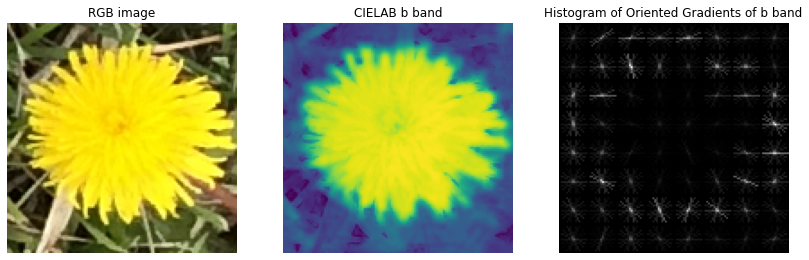

In [3]:
# Visualize the histogram of gradients
sample_image_rgb = imread(filenames[1])
sample_image_lab = rgb2lab(sample_image_rgb)
blue_yellow_band = sample_image_lab[:,:,2]

fv, hog_image = hog(blue_yellow_band, visualize=True, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(4, 4))

plt.figure(figsize=(14, 8))

plt.subplot(1,3,1)
plt.title('RGB image')
plt.imshow(sample_image_rgb)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('CIELAB b band')
plt.imshow(blue_yellow_band) # blue–yellow spectrum
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Histogram of Oriented Gradients of b band')
plt.imshow(hog_image, cmap='gray')
plt.axis('off')

plt.show()

In [4]:
# Print dimensions for our code
print('Features using the entire image:', sample_image_lab.size)
print('Features using HOG:', fv.size)

Features using the entire image: 49152
Features using HOG: 3600


In [5]:
# Create array of feature vectors for each image
n_samples = len(filenames)  # Total number of images
n_features = 128*128 + 3600 # Total pixels in b band plus total features in HOG
X = np.full([n_samples, n_features], np.nan)
y = np.full([n_samples], '', dtype="U10") # Unicode string of 10 characters

for count,name in enumerate(filenames):
    
    # Read tile, flatten, and store in X
    tile = rgb2lab(imread(name))
    tile_hog = hog(tile[:,:,2], orientations=9, pixels_per_cell=(16, 16), cells_per_block=(4, 4))
    fv = np.concatenate( (tile[:,:,2].ravel(), tile_hog.ravel()) )
    X[count,:] = fv

    # Find label and store label in y
    y[count] = name.split('_')[0] # Label is the first element
    

In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.1)

# Train support vector machine
SVM_model = SVC() # Using a Radial Basis Function (default anyways in this version)
SVM_model.fit(X_train, y_train)
SVM_model.score(X_train, y_train)
SVM_predictions = SVM_model.predict(X_test)
SVM_score = SVM_model.score(X_test, y_test)
print(SVM_score)


1.0


In [ ]:
# Scan a full-size image and classify tiles
# This can take time depending on the selected overlapping fraction (delta) and the size of the image
img = rgb2lab(imread('full_images/IMG_6979.JPG'))
b = img[:,:,2] # blue-yellow band in CIELab color space

w = 128
h = 128
delta = round(h/2)
label_boxes = []
row_range = np.arange(0, img.shape[0], delta)
col_range = np.arange(0, img.shape[1], delta)

for row in row_range[:-1]:
    for col in col_range[:-1]:
        if (row+h>img.shape[0]) | (col+w>img.shape[1]):
              continue
        else:
            tile = b[row:row+h, col:col+w]
            tile_hog = hog(tile, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(4, 4))
            fv = np.concatenate( (tile.ravel(), tile_hog.ravel()) )
            fv = np.reshape(fv, (1,-1))

            label = SVM_model.predict(fv)
            box = np.array([col,row,w,h])
             
            if (label == 'dandelion') :
                label_boxes.append(mpatches.Rectangle((col,row),w,h,linewidth=1,edgecolor='r',facecolor='none')) 
                

In [ ]:
# Identify overlapping boxes and merge them into one.
unique_boxes = []
k = 0

while k < len(label_boxes):
    current_box = label_boxes[k]
    x_coord = [current_box.get_x()]
    y_coord = [current_box.get_y()]
    for other_box in label_boxes:
        box_intercept = Bbox.intersection(current_box.get_bbox(), other_box.get_bbox())
        if box_intercept != None:
            area_intercept = box_intercept.height * box_intercept.width
            fraction_intercept = area_intercept/(w*h)
            if fraction_intercept >= 0:
                x_coord.append(other_box.get_x()) 
                y_coord.append(other_box.get_y()) 
                k += 1
    unique_boxes.append(mpatches.Rectangle((np.mean(x_coord),np.mean(y_coord)),w,h,linewidth=1,edgecolor='r',facecolor='none'))
    


In [ ]:
# Display image with classified Dandelions
plt.figure(figsize=(10,10))
plt.imshow(lab2rgb(img))
plt.title('Flowers:' + str(len(unique_boxes)) )

for count,box in enumerate(unique_boxes):
    plt.gca().add_patch(box)
    plt.text(box.get_x()+32, box.get_y()-10, str(count+1), fontsize=16, color='w')
plt.show()

## Limitations

This exercise was written with the goal of learning the basics of object-oriented detection. The script has some limitations:

- The feature vector contains an antire band of color and the histogram of gradients. It may be possible to further reduce the dimensionality of the feature vector.

- The selection of unique label boxes is a crude approach by merging boxes with a specific overlapping area. The method is probably not efficient and sometimes can skip some boxes or keep two overlapping boxes. Use caution when using this part of the code.

- The approach only works with Dandelions fitting within a box of 128 by 128 pixels. The approach will not classify dandelions appear larger or much smaller than this size.